In [22]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [23]:
import numpy as np
import pandas as pd

In [24]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [26]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [27]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [28]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [31]:
#get the column names and datatypes for the measurement table
md = sqlalchemy.MetaData()
measure_table = sqlalchemy.Table('measurement', md, autoload=True, autoload_with=engine)
measure_columns = measure_table.c
for c in measure_columns:
    print(c.name, c.type)

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [32]:
#get the column names and datatypes for the station table
station_table = sqlalchemy.Table('station', md, autoload=True, autoload_with=engine)
station_columns = station_table.c
for c in station_columns:
    print(c.name, c.type)

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [33]:
# Prompt: Design a query to retrieve the last 12 months of precipitation data and plot the results
# Step 1: Calculate the date 1 year ago from today
# FYI - the latest date in the db is 8.24.17, so the following queries are based around that max date
# Here is the query I would write to base it on today: ly = dt.today() - dt.timedelta(days=365)

#find the most recent date in the dataset by ordering according the set and selecting first object
ty = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

#convert this point into a datetime object
tyd = dt.datetime.strptime(ty, '%Y-%m-%d')

#subtract 365 days from this date in order to select a year previous
ly = tyd - dt.timedelta(days=365)

#convert the LY number back into a string in order to communicate with the db accordingly
lys = ly.strftime('%Y-%m-%d')

In [34]:
# Step 2: Perform a query to retrieve the data and precipitation scores according to TY/LY in Step 1

year_history = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > lys).\
    order_by(Measurement.date).all()

In [35]:
# Step 3: Save the query results as a Pandas DataFrame and set the index to the date column

precip = pd.DataFrame(year_history)
#convert the 'date' column to datetime in order to parse over the year
precip['date'] = precip['date'].astype('datetime64[ns]')
#group by date in order to clean up the data
precip_df = pd.DataFrame(precip.groupby(['date']).agg({'prcp':'sum'}))
precip_df.head()

,prcp
date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


<IPython.core.display.Javascript object>


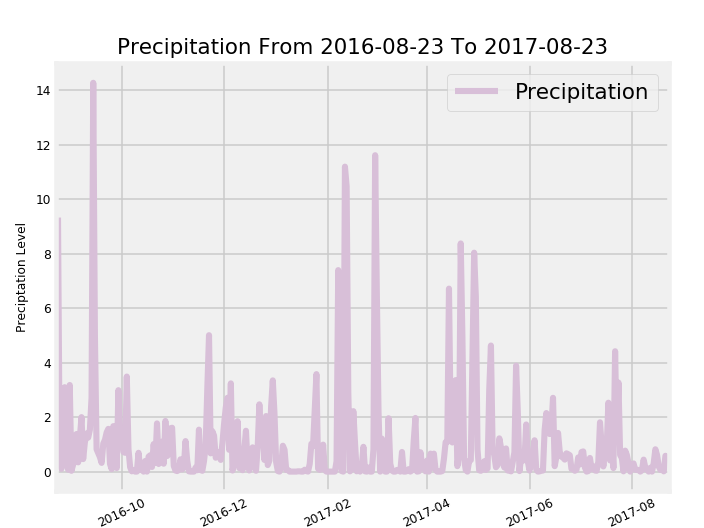

In [63]:
# Step 4: Use Pandas Plotting with Matplotlib to plot the data and rotate the xticks for the dates

fig, ax = plt.subplots(1, 1)

line1, = ax.plot(precip_df.index, precip_df['prcp'], color='thistle')
ax.legend(['Precipitation'])
plt.title(f"Precipitation From {lys} To {ty}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Preciptation Level")

ax.set_xlim(ly, tyd)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.xticks(rotation=25)

for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(8)

plt.show()

In [37]:
# Prompt: Use Pandas to calcualte the summary statistics for the precipitation data
summ_df = pd.DataFrame(precip_df['prcp'].describe())
summ_df

,prcp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [38]:
# Prompt: How many stations are available in this dataset?
stations = (session.query(func.count(Measurement.station.distinct()))).scalar()
print(stations)

9


In [39]:
# Prompt: What are the most active stations? List the stations and the counts in descending order.
station_activity = engine.execute('SELECT station, COUNT(station) FROM measurement GROUP BY station ORDER BY COUNT(station) DESC')
for s in station_activity:
    print(s)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [40]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_temp = session.query(func.min(Measurement.tobs)).filter_by(station='USC00519281').scalar()
max_temp = session.query(func.max(Measurement.tobs)).filter_by(station='USC00519281').scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter_by(station='USC00519281').scalar()
print(f'Min Temp: {min_temp}, Max Temp: {max_temp}, Avg Temp: {avg_temp}')

Min Temp: 54.0, Max Temp: 85.0, Avg Temp: 71.66378066378067


In [49]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#pull the data for USC00519281 into a DataFrame
station_df = pd.read_sql('SELECT * FROM measurement WHERE station=\'USC00519281\' AND date>=(?)', engine.connect(), params=(lys,))
station_df.head()

,id,station,date,prcp,tobs
0,14608,USC00519281,2016-08-23,1.79,77.0
1,14609,USC00519281,2016-08-24,2.15,77.0
2,14610,USC00519281,2016-08-25,0.06,80.0
3,14611,USC00519281,2016-08-26,0.01,80.0
4,14612,USC00519281,2016-08-27,0.12,75.0


<IPython.core.display.Javascript object>


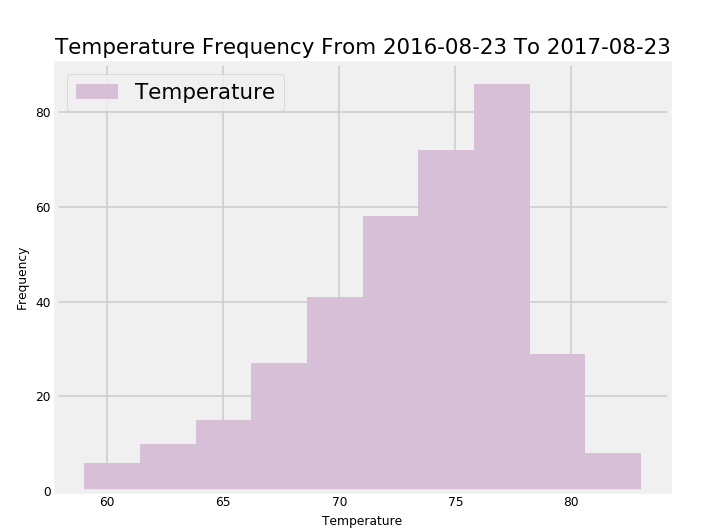

In [64]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

fig, ax = plt.subplots()

ax.hist(station_df['tobs'], color='thistle')
ax.legend(['Temperature'])
plt.title(f"Temperature Frequency From {lys} To {ty}", fontsize=14)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(8)

plt.show()

In [65]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [66]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-01-15', '2017-01-25'))

[(66.0, 71.6086956521739, 80.0)]


<IPython.core.display.Javascript object>


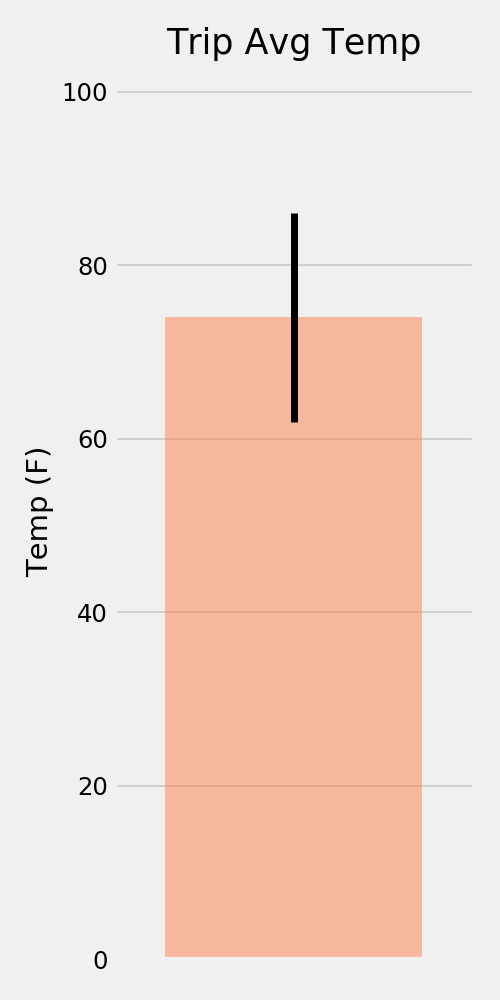

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


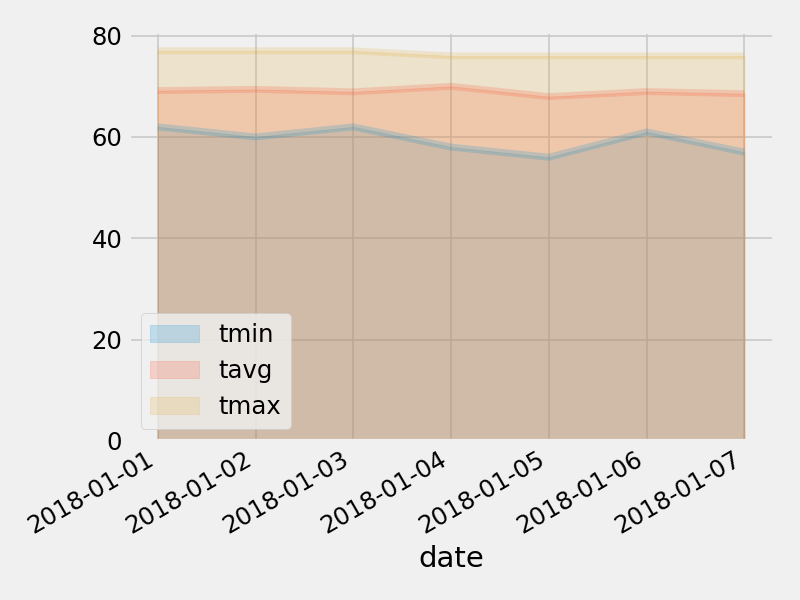

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
